In [147]:
import json
import random
import matplotlib.pyplot as plt
import datetime
import numpy as np
# for creating animation for sensitivity analysis
import imageio as iio
from IPython.display import Image, display

def get_date(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime.datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + datetime.timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month} {Day}, {Year}"
    formatted_date = target_date.strftime("%B %d, %Y")
    
    return formatted_date
   
def get_days_in_year(year):
    if year % 4 == 0:
        if year % 100 == 0:
            if year % 400 == 0:
                return 366  # Leap year (divisible by 400)
            else:
                return 365  # Not a leap year (divisible by 100 but not by 400)
        else:
            return 366  # Leap year (divisible by 4 but not by 100)
    else:
        return 365  # Not a leap year
    
# calc future temperature variability rises from single reference points (observed daily temperatures)
def calc_max_rise_plus_days(filepath, days_out, rise_threshold, min_year):
    # Step 1: Load and parse the JSON file
    with open(filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    # Include only years from min_year on
    filtered_data = [entry for entry in data if (len(entry['name']) == 4 and int(entry['name']) >= min_year)]

    # for work on monthly-mean-land-ocean-temp (not relavant to this project)
    # calculate data for monthly-mean-land-ocean-temp ?
    calculate_for_monthly_mean_land_ocean_temp = False
    start_day = 182
    end_day = 212
    last_day_current_data = 198
    # Calculate average mean for ~July (~day 182-212), to compare to July 2019
    if calculate_for_monthly_mean_land_ocean_temp:
        mean_data = [entry for entry in data if entry['name'] == '1979-2000 mean'][0]['data']
        mean_month_avg = np.average(mean_data[start_day-1:end_day])
        print(f"Monthly mean for July from all years' daily data: {round(mean_month_avg, 3)}")
        
        july_2019_data = [entry for entry in data if entry['name'] == '2019'][0]['data']
        month_avg_2019 = np.average(july_2019_data[start_day-1:end_day])
        print(f"Monthly mean for July 2019 daily data: {round(month_avg_2019, 3)}")
        
        july_2023_data = [entry for entry in data if entry['name'] == '2023'][0]['data']
        month_avg_2023 = np.average(july_2023_data[start_day-1:last_day_current_data])
        print(f"Monthly mean for July 2023 daily data: {round(month_avg_2023, 3)}")
        print(f"July 2019 mean anomaly from daily data: {round(month_avg_2019 - mean_month_avg, 3)}")
        print(f"July 2023 mean anomaly from daily data: {round(month_avg_2023 - mean_month_avg, 3)}")
        print(f"July 2023 mean - July 2019 mean: {round(month_avg_2023 - month_avg_2019, 3)}")
    
    
    # only for counting years of data (current year is incomplete so reduce by 1)
    num_years_of_complete_data = len(filtered_data) - 1
    
    # Step 4: Extract temperature series data
    temp_series = []  # Assuming 365 days in a year, no leap years
    start_year = 0
    for entry in filtered_data:
        if start_year == 0:
            start_year = int(entry['name'])
        for i, temp in enumerate(entry['data']):
            # ignore null values (null place holders at the end of the data for non-leap years)
            if temp:
                temp_series.append(temp)
    
    # hold the maximum rise in temperatures relative to the current day, for the next days_out days
    #max_rise_temps = [[] for _ in range(366)]
    max_rise_temps = np.zeros(366)
    rise_occurrences = np.zeros(366)
    rise_avg_total = np.zeros(366)
    rise_threshold_occurrences = np.zeros(366)
    cur_year = start_year
    days_in_cur_year = get_days_in_year(cur_year)
    cur_year_days_done = 0
    temp_series_len = len(temp_series)
    # calculate max for every day except the last day of observations (since we expect a days_out > 0)
    for i in range(0, temp_series_len - 1):
        
        # end_range should be i + 1 + days_out
        # so for days_out of 1, the range will be i + 1, to i + 1 + 1, which is one day
        start_range = i + 1
        end_range = start_range + days_out
        if end_range > temp_series_len:
            # no further than the length of the series
            end_range = temp_series_len
        
        # get the next days_out max temp
        max_rise = 0
        ref_temp = temp_series[i]
        for j in range(start_range, end_range):
            rise = temp_series[j] - ref_temp
            if rise > 0:
                rise_occurrences[cur_year_days_done] += 1
                rise_avg_total[cur_year_days_done] += rise
                if rise > rise_threshold:
                    rise_threshold_occurrences[cur_year_days_done] += 1
            if rise > max_rise:
                max_rise = rise
            if max_rise_temps[cur_year_days_done]:
                if max_rise > max_rise_temps[cur_year_days_done]:
                    max_rise_temps[cur_year_days_done] = max_rise
            else:
                max_rise_temps[cur_year_days_done] = max_rise
        
        # keep track of current day of the year
        cur_year_days_done += 1
        # move to next year when done with current year
        if cur_year_days_done == days_in_cur_year:
            cur_year += 1
            days_in_cur_year = get_days_in_year(cur_year)
            cur_year_days_done = 0
    
    return [max_rise_temps, rise_occurrences, num_years_of_complete_data, rise_avg_total, rise_threshold_occurrences]
    
    
def graph_max_rise_plus_days(filepath, extrapolate_year, days_out, start_day_1_index, rise_threshold, include_days_plus_minus, zoom_max_rise_days, min_year, sensitivity_analysis):
    fig1, ax = plt.subplots(figsize=(10, 6))
    if sensitivity_analysis is False:
        fig2, ac = plt.subplots()
    fig3, ap = plt.subplots(figsize=(10, 6))
    
    for d in days_out:
        max_rise_temps, rise_occurrences, num_years_of_complete_data, rise_avg_total, rise_threshold_occurrences = calc_max_rise_plus_days(filepath, d, rise_threshold, min_year)
        
        rise_avg = np.zeros(len(rise_avg_total))
        for i in range(0, len(rise_avg)):
            if rise_occurrences[i] > 0:
                avg = rise_avg_total[i] / rise_occurrences[i]
            else:
                avg = 0
            rise_avg[i] = avg
        
        # day of year (1-index)
        i = start_day_1_index
        if sensitivity_analysis is False:
            print(f"Max 2m Temp Rise (historically) {d} days out from " + get_date(i, extrapolate_year))
            print(round(max_rise_temps[i-1],3))
            print("")
        
            print(f"# Occurences 2m Temp Rise (historically) {d} days out from " + get_date(i, extrapolate_year))
            print(str(int(rise_occurrences[i-1])))
            print("")

        # rough number since it will be either 44 or 45 through out the year
        denominator_days = d * num_years_of_complete_data
        # rise_occurences is the total number of days (across all years) that rises were counted for out of the d number of days looking forward from the reference day
        # since there are only d days and a number of years in the record we only looked at denominator_days for rise_occurences
        rise_prob = rise_occurrences[i-1] / denominator_days
        pct = round(rise_prob * 100,2)
        if sensitivity_analysis is False:
            print(f"Chance of 2m temp rise {d} days out from " + get_date(i, extrapolate_year))
            print(str(pct) + " %")
            print("")

        # In addition to using a single reference day, let's look at the probabilities forward/backwards for temp rise
        start = i - include_days_plus_minus
        end = i + include_days_plus_minus
        days_in_year = get_days_in_year(extrapolate_year)
        for s in range(start, end + 1):
            # 366 for non-leap year will become 0
            m = s % (days_in_year + 1)
            # rough number since it will be either 44 or 45 through out the year
            denominator_days = d * num_years_of_complete_data
            # rise_occurences is the total number of days (across all years) that rises were counted for out of the d number of days looking forward from the reference day
            # since there are only d days and a number of years in the record we only looked at denominator_days for rise_occurences
            rise_prob = rise_occurrences[m-1] / denominator_days
            pct = round(rise_prob * 100,2)
            #print(f"Chance of temp rise {d} days out from " + get_date(m, extrapolate_year))
            #print(str(pct) + " %")
            #print("")

        avg_rise = round(rise_avg[i-1],3)
        if sensitivity_analysis is False:
            print("Average 2m temperature rise conditioned on only days that have positive rise:")    
            print(f"{avg_rise}")
            print("")
        
        expected_temp_rise = round(rise_prob * rise_avg[i-1], 3)
        rise_threshold_str = str(round(rise_threshold, 3))
        if sensitivity_analysis is False:
            print(f"(Max) Expected Positive Temperature rise {d} days out from " + get_date(i, extrapolate_year))
            print(f"{expected_temp_rise}")
            print("")

            print(f"# Occurrences 2m Temp Rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(i, extrapolate_year))
            print(str(int(rise_threshold_occurrences[i-1])))
            print("")
        
        if rise_occurrences[i-1] > 0:
            ratio_threshold_occ = rise_threshold_occurrences[i-1] / rise_occurrences[i-1]
        else:
            ratio_threshold_occ = 0
        if sensitivity_analysis is False:
            print(f"Ratio of Occurrences in 2m Temp Rise to Occurrences exceeding a {rise_threshold_str} threshold {d} days out from " + get_date(i, extrapolate_year))
            print(round(ratio_threshold_occ, 3))
            print("")
        
        prob_new_record_from_reference_day = ratio_threshold_occ * rise_prob
        new_record_pct = round(prob_new_record_from_reference_day * 100,2)
        if sensitivity_analysis is False:
            print(f"Chance of 2m temp rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(i, extrapolate_year))
            print(str(round(new_record_pct, 2)) + " %")
            print("")
            print("")

        # In addition to using a single reference day, let's look at the probabilities forward/backwards for temp rise meeting threshold
        start = i - include_days_plus_minus
        end = i + include_days_plus_minus
        days_in_year = get_days_in_year(extrapolate_year)
        # store values for sensitivity graph
        chances_exceeding_threshold_y = []
        chances_exceeding_threshold_x = []
        
        for s in range(start, end + 1):
            # 366 for non-leap year will become 0
            m = s % (days_in_year + 1)
            if rise_occurrences[m-1] > 0:
                ratio = rise_threshold_occurrences[m-1] / rise_occurrences[m-1]
            else:
                ratio = 0
            ratio_threshold_occ = ratio
            prob_new_record_from_reference_day = ratio_threshold_occ * rise_prob
            new_record_pct = round(prob_new_record_from_reference_day * 100,2)
            chances_exceeding_threshold_y.append(new_record_pct)
            chances_exceeding_threshold_x.append(m)
            #print(f"Chance of 2m temp rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(m, extrapolate_year))
            #print(round(new_record_pct, 2))
        if sensitivity_analysis is False:
            print("")
            print("")
        
        # Step 6: Create graphs
        x = range(1, len(max_rise_temps) + 1)
        y = max_rise_temps
        lbl = 'Max Temp Rise for ' + str(d) + ' days out'
        
        if zoom_max_rise_days > 0:
            zoom_start = start_day_1_index - zoom_max_rise_days - 1
            zoom_end = start_day_1_index + zoom_max_rise_days
            ax.set_xticks(x[zoom_start:zoom_end])
            ax.set_xticklabels(x[zoom_start:zoom_end])
            # add line for threshold to rise
            ax.axhline(y=rise_threshold, linestyle='dashed', color='red')
            # zoom in
            if sensitivity_analysis:
                # set a limit y % to make all graphs equal scale
                ax.set_ylim(0, 0.6)
            ax.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label=lbl)
        else:
            # add line for threshold to rise
            ax.axhline(y=rise_threshold, linestyle='dashed', color='red')
            ax.plot(x, y, label=lbl)

        x2 = range(1, len(max_rise_temps) + 1)
        y2 = rise_occurrences
        lbl2 = '# Occurrences of Global 2m Temp Rising ' + str(d) + ' days out'
        if sensitivity_analysis is False:
            ac.plot(x2, y2, label=lbl2)
        
        lbl3 = '% Chance exceeding threshold, ' + str(d) + ' days out'
        
        if sensitivity_analysis:
            # set a limit y % to make all graphs equal scale
            ap.set_ylim(0, 20)
        ap.plot(chances_exceeding_threshold_x, chances_exceeding_threshold_y, label=lbl3)

    ax.set_xlabel('Day')
    ax.set_ylabel('Max Temp Rise')
    lbl = 'Max Rise in Global 2m Temp Rise for up to ' + str(d) + ' days out'
    if min_year > 0:
        lbl += ' (' + str(min_year) + '-)'
    ax.set_title(lbl)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    if sensitivity_analysis is False:
        ac.set_xlabel('Day')
        ac.set_ylabel('# Occurrences of 2m Temp Rise')
        lbl = '# Occurrences of Global 2m Temp Rising for up to ' + str(d) + ' days out'
        if min_year > 0:
            lbl += ' (' + str(min_year) + '-)'
        ac.set_title(lbl)
        ac.legend(loc='upper right', bbox_to_anchor=(1.95, 1))

    # Sensitivity analysis
    ap.set_xlabel('Reference day (from which we count temp rises after in time)')
    ap.set_ylabel('% Chance of exceeding the threshold')
    lbl = '% Chance of 2m temp rise exceeding a ' + rise_threshold_str + ' threshold, counting forward from reference day'
    if min_year > 0:
        lbl += ' (' + str(min_year) + '-)'
    ap.set_title(lbl)
    ap.legend(loc='upper right', bbox_to_anchor=(1.75, 1))

    if sensitivity_analysis is False:
        plt.show()
        return [None, None]
    else:
        framename_fig1 = 'sensitivity_fig1_' + str(min_year) + '.png'
        framename_fig3 = 'sensitivity_fig3_' + str(min_year) + '.png'
        fig1.savefig(framename_fig1)
        fig3.savefig(framename_fig3)
        plt.close(fig1)
        plt.close(fig3)
        return framename_fig1, framename_fig3


In [148]:
#### CONFIG FOR MAIN PARAMETERS
# current year want to extrapolate data for that already have partial data
extrapolate_year = 2023
# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
filepath = 'cfsr_world_t2_day.json'

Creating graphs, please wait...


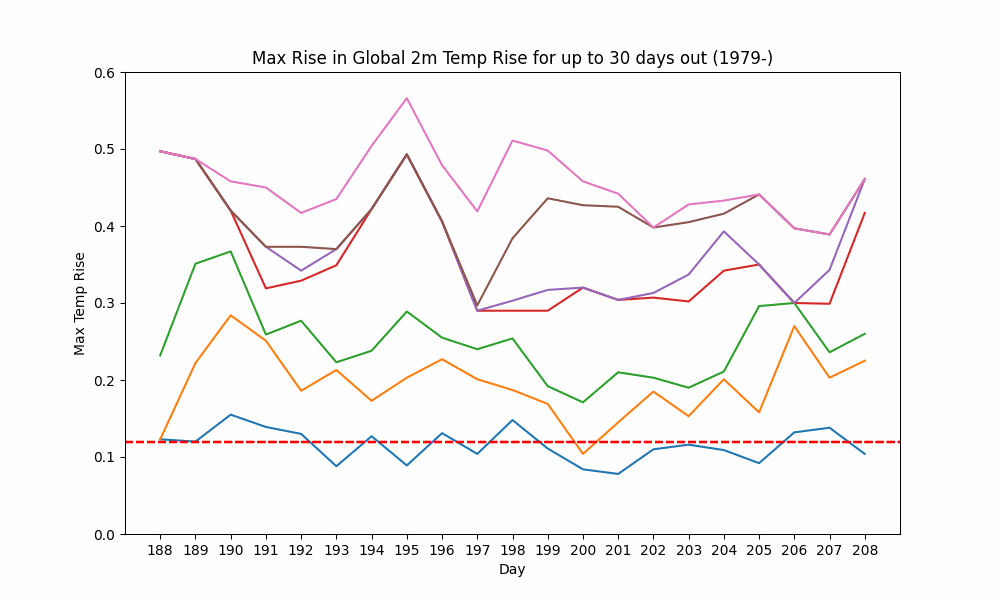

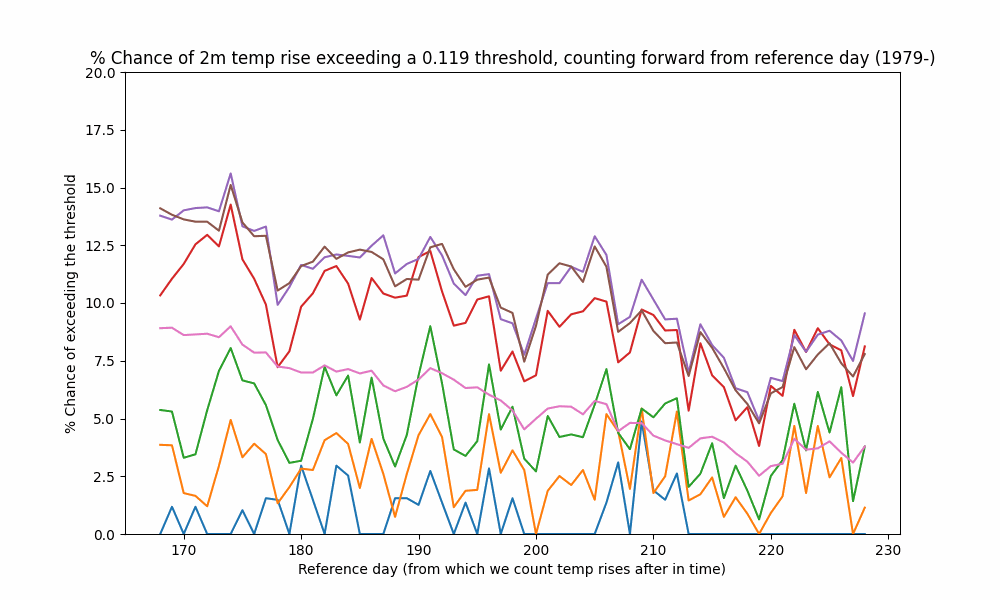

In [153]:
# start of day of year to project out from (last day of observed data: July 17, 2023 = 198)
start_day_1_index = 198
# threshold in rise to count occurences for (the record temperature - the most recent observation temperature)
rise_threshold = 17.233 - 17.114
# days out from last day of observed data to do counts for (14 + July 17 = July 31)
days_out = [1, 2, 3, 7, 10, 14, 30]
#days_out = [1, 2, 3, 7, 22, 30]

# the temp variability changes throughout the year
# include probabilities for days prior/after reference day
include_days_plus_minus = 30

# the year for extrapolation
extrapolate_year = 2023

# zoom on max rise days: how many days +- to zoom in on start_day_1_index
# set to 0 for full year
zoom_max_rise_days = 10

# exclude data from before min_year (for era statistics and sensitivity analysis)
# set to 0 for all years (or a year like 2016 to exclude years before 2016)
min_year = 0
# create graph animations over range of min_year (only final graph animation, and no occurences graph or text-based stats)
sensitivity_analysis = True

# main code
frames_fig1 = []
frames_fig3 = []
if sensitivity_analysis:
    print('Creating graphs, please wait...')
    for min_year in range(1979, 2023):
        [framename_fig1, framename_fig3] = graph_max_rise_plus_days(filepath, extrapolate_year, days_out, start_day_1_index, rise_threshold, include_days_plus_minus, zoom_max_rise_days, min_year, sensitivity_analysis)
        frames_fig1.append(iio.v3.imread(framename_fig1))
        frames_fig3.append(iio.v3.imread(framename_fig3))
    imageio.mimsave("sensitivity_analysis_max_rise.gif", frames_fig1, duration=500, loop=0)
    imageio.mimsave("sensitivity_analysis_prob.gif", frames_fig3, duration=500, loop=0)
    # Display the animated gif
    display(Image(filename="sensitivity_analysis_max_rise.gif"))
    display(Image(filename="sensitivity_analysis_prob.gif"))
else:
    [framename1, framename3] = graph_max_rise_plus_days(filepath, extrapolate_year, days_out, start_day_1_index, rise_threshold, include_days_plus_minus, zoom_max_rise_days, min_year, sensitivity_analysis)
